## Домашнее задание по теме «Рекомендации на основе содержания»

Использовать dataset MovieLens https://grouplens.org/datasets/movielens/latest/

 * Построить рекомендации (регрессия, предсказываем оценку) для пользователя на фичах:
   отдельно TF-IDF на тегах и жанрах
 * Средние оценки (+ median, variance, etc.) пользователя и фильма
 * Оценить RMSE на тестовой выборке

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
%matplotlib inline

## Part 1

In [2]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
#преобразуем genre
def change_genre(str_):
    return ' '.join(str_.replace(' ','').replace('-', '').split('|'))

movies['genres_for_tfidf'] = [change_genre(g) for g in movies['genres']]

In [7]:
movies.drop('genres',axis=1,inplace=True) #дропнем старый столбец с жанрами
movies.head()

,movieId,title,genres_for_tfidf
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
#добавим в movies все теги по каждому фильму
movies['tags_for_tfidf'] = movies.apply(lambda r: ' '.join(tags[tags['movieId']==r['movieId']]['tag'].values), axis=1)

In [9]:
movies.head()

,movieId,title,genres_for_tfidf,tags_for_tfidf
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old
3,4,Waiting to Exhale (1995),Comedy Drama Romance,
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake


In [10]:
# посчитаем кол-во вхождений слов
features = ['genres_for_tfidf','tags_for_tfidf']
df_concat = movies
for feature in features:
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(df_concat[feature])
    # для матрицы X_train_counts посчитаем tfidf
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts).todense()
    # соберем все в одну матрицу
    columns = [None for i in range(len(count_vect.vocabulary_))]
    for f in count_vect.vocabulary_:
        columns[count_vect.vocabulary_[f]] = f
    df_tfidf = pd.DataFrame(X_train_tfidf, columns=columns)
    df_concat = pd.concat(((df_concat.drop(feature,1)), df_tfidf), axis = 1)
df_concat.head()

,movieId,title,action,adventure,animation,children,comedy,crime,documentary,drama,...,york,you,younger,your,zellweger,zither,zoe,zombie,zombies,zooey
0,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#добавим целевую переменную rating (он может отличаться для каждого пользователя)
movies_with_ratings = pd.merge(df_concat,ratings, on = 'movieId')
movies_with_ratings.head()

,movieId,title,action,adventure,animation,children,comedy,crime,documentary,drama,...,your,zellweger,zither,zoe,zombie,zombies,zooey,userId,rating,timestamp
0,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0,964982703
1,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4.0,847434962
2,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,4.5,1106635946
3,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,2.5,1510577970
4,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,4.5,1305696483


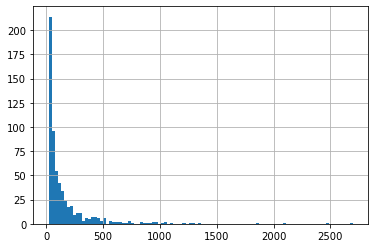

In [12]:
# Content based имеет смысл только для пользователей с "историей", поэтому возьмем пользователей с высоким кол-во оценок
#посмотрим на кол-во оценок по пользователю, вдруг есть выбросы справа
movies_with_ratings.groupby('userId').timestamp.count().hist(bins = 100) 

In [13]:
# есть немного пользователей - предоставивших более 1500 оценок, 
# маловероятно, что они успели столько просмотреть - это около 5 лет ежедневного просмотра,
# для таких пользователей есть вероятность - что они смотрят все подряд:-)
# возьмем 10 пользователей, которые проставили много оценок, но не попали в правый хвост распределения
user_views = ratings.groupby('userId')[['movieId']].count().sort_values('movieId', ascending=False)
test_users = user_views[user_views['movieId'] < 501].head(20)

In [14]:
# для выбранной выборки пользователей произведем выбор наилучшей модели для прогнозирования рейтинга
columns_for_drop = ['userId','movieId','timestamp','title','rating']
random_state = 42
best_model = {}
for user in test_users.index:
    models = [Lasso, Ridge, DecisionTreeRegressor]
    results = {}
    df = movies_with_ratings[movies_with_ratings['userId'] == user]
    df_user, df_user_test = train_test_split(df, test_size = 0.1, random_state = random_state)
    X, y = df_user.drop(columns_for_drop, axis = 1, inplace = False), df_user['rating']
    X_test = df_user_test.drop(columns_for_drop, axis = 1, inplace = False)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = random_state)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    X_test = sc.transform(X_test)
    y_test = df_user_test['rating']
    for m in tqdm(models):
        model = m()
        model.fit(X_train, y_train)
        predict_train = model.predict(X_train)
        rmse_train = mean_squared_error(predict_train, y_train)
        predict_val = model.predict(X_val)
        rmse_val = mean_squared_error(predict_val, y_val)
        predict_test = model.predict(X_test)
        rmse_test = mean_squared_error(predict_test, y_test)
        results[m.__name__] = [model,rmse_train,rmse_val,rmse_test]
    best_for_user = sorted(results.values(), key = lambda r: r[2], reverse = False)[0]
    best_model[user] = {'model':best_for_user[0],'rmse_train': round(best_for_user[1],4),'rmse_test': round(best_for_user[3],4)}

In [27]:
# посмотрим на среднюю RMSE по юзерам для тестовой выборки
res = []
for value in best_model.values():
    res.append(value['rmse_test'])
print(f'RMSE_average for test: {round(np.mean(res),4)}')

RMSE_average for test: 0.9824


In [79]:
# видим, что лучше всего отрабатывает Lasso, на удивление плохо отрабатывал DecisionTreeRegressor, хотя при большом значении 
# признаков на мой взгляд из выбранных моделей он должен был дать наилучшую оценку

## Part 2

In [28]:
#посчитаем mean,median,var for user and movie
users_rating = ratings.groupby('userId')['rating'].agg(['mean','median','var']).reset_index()
movie_rating = ratings.groupby('movieId')['rating'].agg(['mean','median','var']).reset_index()

In [29]:
users_rating.head()

,userId,mean,median,var
0,1,4.366379,5.0,0.640077
1,2,3.948276,4.0,0.649015
2,3,2.435897,0.5,4.370783
3,4,3.555556,4.0,1.727132
4,5,3.636364,4.0,0.980973


In [30]:
#добавим в качестве фичей средние оценки, медиану и дисперсию
movies_with_ratings = movies_with_ratings.merge(users_rating, on='userId')
movies_with_ratings = movies_with_ratings.merge(movie_rating, on='movieId')
movies_with_ratings.head()

,movieId,title,action,adventure,animation,children,comedy,crime,documentary,drama,...,zooey,userId,rating,timestamp,mean_x,median_x,var_x,mean_y,median_y,var_y
0,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,1,4.0,964982703,4.366379,5.0,0.640077,3.92093,4.0,0.69699
1,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,5,4.0,847434962,3.636364,4.0,0.980973,3.92093,4.0,0.69699
2,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,7,4.5,1106635946,3.230263,3.5,1.767820,3.92093,4.0,0.69699
3,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,15,2.5,1510577970,3.448148,3.5,1.284605,3.92093,4.0,0.69699
4,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.0,...,0.0,17,4.5,1305696483,4.209524,4.0,0.258562,3.92093,4.0,0.69699


In [32]:
#заменим nan на 0
movies_with_ratings.fillna(0,inplace=True)

In [33]:
# повторим для датафрейма с новыми фичами
columns_for_drop = ['userId','movieId','timestamp','title','rating']
random_state = 42
best_model2 = {}
for user in test_users.index:
    models = [Lasso, Ridge, DecisionTreeRegressor]
    results = {}
    df = movies_with_ratings[movies_with_ratings['userId'] == user]
    df_user, df_user_test = train_test_split(df, test_size = 0.1, random_state = random_state)
    X, y = df_user.drop(columns_for_drop, axis = 1, inplace = False), df_user['rating']
    X_test = df_user_test.drop(columns_for_drop, axis = 1, inplace = False)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = random_state)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    X_test = sc.transform(X_test)
    y_test = df_user_test['rating']
    for m in tqdm(models):
        model = m()
        model.fit(X_train, y_train)
        predict_train = model.predict(X_train)
        rmse_train = mean_squared_error(predict_train, y_train)
        predict_val = model.predict(X_val)
        rmse_val = mean_squared_error(predict_val, y_val)
        predict_test = model.predict(X_test)
        rmse_test = mean_squared_error(predict_test, y_test)
        results[m.__name__] = [model,rmse_train,rmse_val,rmse_test]
    best_for_user = sorted(results.values(), key = lambda r: r[2], reverse = False)[0]
    best_model2[user] = {'model':best_for_user[0],'rmse_train': round(best_for_user[1],4),'rmse_test': round(best_for_user[3],4)}

In [35]:
best_model2

{525: {'model': Ridge(), 'rmse_train': 0.2381, 'rmse_test': 0.3426},
 57: {'model': Ridge(), 'rmse_train': 0.2871, 'rmse_test': 0.3663},
 381: {'model': Ridge(), 'rmse_train': 0.2954, 'rmse_test': 0.4791},
 368: {'model': Ridge(), 'rmse_train': 0.1937, 'rmse_test': 0.4037},
 509: {'model': Ridge(), 'rmse_train': 0.1811, 'rmse_test': 0.2617},
 469: {'model': Ridge(), 'rmse_train': 0.2548, 'rmse_test': 0.5864},
 560: {'model': Ridge(), 'rmse_train': 0.1318, 'rmse_test': 0.3282},
 462: {'model': Lasso(), 'rmse_train': 1.0865, 'rmse_test': 1.7871},
 292: {'model': Ridge(), 'rmse_train': 0.2345, 'rmse_test': 0.5762},
 21: {'model': Ridge(), 'rmse_train': 0.3322, 'rmse_test': 0.5652},
 597: {'model': Ridge(), 'rmse_train': 0.363, 'rmse_test': 0.5024},
 42: {'model': Ridge(), 'rmse_train': 0.5055, 'rmse_test': 1.2503},
 294: {'model': Ridge(), 'rmse_train': 0.6145, 'rmse_test': 0.9486},
 160: {'model': Ridge(), 'rmse_train': 0.8743, 'rmse_test': 1.6909},
 580: {'model': Ridge(), 'rmse_train':

In [37]:
# посмотрим на среднюю RMSE по юзерам для тестовой выборки
res2 = []
for value in best_model2.values():
    res2.append(value['rmse_test'])
print(f'RMSE_average for test: {round(np.mean(res2),4)}')

RMSE_average for test: 0.7686


In [38]:
# при добавлении новых фичей RMSE улучшился, здесь уже лучшая модель стала Ridge

## Part 3

In [52]:
#спрогнозируем рейтинг для тестовой выборки по наилучшей модели
final_model = Ridge()
user = test_users.index[0] #берем любого пользователя из test_users, по которому лучшая модель была Ridge
df = movies_with_ratings[movies_with_ratings['userId'] == user]
df_user, df_user_test = train_test_split(df, test_size = 0.1, random_state = random_state)
X, y = df_user.drop(columns_for_drop, axis = 1, inplace = False), df_user['rating']
X_test = df_user_test.drop(columns_for_drop, axis = 1, inplace = False)
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = random_state)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
y_test = df_user_test['rating']
final_model.fit(X_train, y_train)
predict_train = final_model.predict(X_train)
rmse_train = mean_squared_error(predict_train, y_train)
predict_val = final_model.predict(X_val)
rmse_val = mean_squared_error(predict_val, y_val)
predict_test = final_model.predict(X_test)
rmse_test = mean_squared_error(predict_test, y_test)
result = pd.concat([df_user_test.reset_index().drop('index',1),
                      pd.DataFrame(columns=['predicted_rating'],data=final_model.predict(X_test))],
                     axis=1)
result[columns_for_drop + ['predicted_rating'] + [c for c in result.columns if c not in columns_for_drop + ['predicted_rating']]]

,userId,movieId,timestamp,title,rating,predicted_rating,action,action,adventure,adventure,...,zoe,zombie,zombies,zooey,mean_x,median_x,var_x,mean_y,median_y,var_y
0,525,6296,1476476997,"Mighty Wind, A (2003)",4.0,3.987423,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,3.750000,4.00,0.567308
1,525,597,1476476752,Pretty Woman (1990),4.0,3.402480,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,3.485185,3.50,0.719928
2,525,3882,1476479691,Bring It On (2000),3.5,2.635749,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,2.691176,2.75,1.091132
3,525,122882,1476475970,Mad Max: Fury Road (2015),4.5,4.148884,0.456925,0.000000,0.520091,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,3.819149,4.00,0.906799
4,525,6863,1476479501,School of Rock (2003),3.0,4.020582,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,3.401515,3.50,0.609382
5,525,35836,1476479408,"40-Year-Old Virgin, The (2005)",3.0,3.491415,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,3.547297,3.50,0.864171
6,525,4069,1476476930,"Wedding Planner, The (2001)",3.0,2.908484,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,2.909091,2.75,0.991342
7,525,4226,1476476441,Memento (2000),4.0,3.841338,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,4.122642,4.50,0.818725
8,525,364,1476476559,"Lion King, The (1994)",4.0,3.312808,0.000000,0.000000,0.328929,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,3.941860,4.00,0.701278
9,525,54190,1476478452,Across the Universe (2007),4.0,3.895993,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,3.542,3.5,0.532301,4.045455,4.00,0.522727


In [55]:
rmse_final = round(mean_squared_error(result['predicted_rating'],result['rating']),4)

In [56]:
rmse_final #средний RMSE по тестовой выборке лучше полученного при выборе модели

0.3426